In [1]:
# Getting the necessary imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
from sklearn.preprocessing import StandardScaler
from summarytools import dfSummary
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

# Data Source:
https://ec.europa.eu/eurostat/databrowser/view/avia_paocc/default/table?lang=en&category=avia.avia_pa.avia_pao

# Towards Data Science Article Link for Time Series: 
https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6/

## Meaning of some columns
### The tra_meas column categorizes the passenger data as follows:

#### tra_meas Values
* Passengers carried: Total number of passengers transported by air, regardless of whether they are arriving or departing. This is the total passenger count for flights associated with Germany (e.g., flights to/from/within Germany). In your dataset, there are 277 entries with this measurement.

* Passengers carried (arrivals): Number of passengers who arrived in Germany on flights. This counts passengers disembarking in Germany (e.g., at German airports like Frankfurt or Munich). There are 277 entries for this.

* Passengers carried (departures): Number of passengers who departed from Germany on flights. This counts passengers boarding flights leaving Germany. There are 277 entries for this.

* Passengers on board: Total number of passengers on board flights associated with Germany, regardless of arrival or departure. This might overlap with "Passengers carried" but could reflect a slightly different reporting metric (e.g., passengers on flights operated by German carriers). There are 277 entries for this.

* Passengers on board (arrivals): Number of passengers on board flights arriving in Germany. This is similar to "Passengers carried (arrivals)" but might reflect passengers on the flight rather than those who disembark (e.g., including transit passengers). There are 277 entries for this.

* Passengers on board (departures): Number of passengers on board flights departing from Germany. Similar to "Passengers carried (departures)" but might include transit passengers. There are 277 entries for this.

* unit
* tra_cov
* geo: Location of where the passengers are landing and leaving from
* TIME_PERIOD: Which year and month we are referring to with for Germany starting from 2002-January-01 to 2025-May
* Total_Passengers: # of Passengers boarding and departing in and out of Germany
* EMA_0.3: Estimated Moving Average with a specific alpha value (0.3)
* EMA_0.8: Estimated Moving Average with a specific alpha value (0.3)
* EMA_0.7: Estimated Moving Average with a specific alpha value (0.3) 
* EMA_0.75: Estimated Moving Average with a specific alpha value (0.3)
* Rolling_window2: Another moving average with rolling windows 2

In [2]:
# ob_cleaned.columns

In [3]:
air = pd.read_csv('dataset/airpassenger.csv')

In [4]:
air.head()

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
0,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-01,935901,NaN,NaN
1,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-02,966771,NaN,NaN
2,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-03,1184268,NaN,NaN
3,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-04,1143982,NaN,NaN
4,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Austria,2002-05,1326116,NaN,NaN


In [5]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     54555 non-null  object 
 1   LAST UPDATE  54555 non-null  object 
 2   freq         54555 non-null  object 
 3   unit         54555 non-null  object 
 4   tra_meas     54555 non-null  object 
 5   tra_cov      54555 non-null  object 
 6   schedule     54555 non-null  object 
 7   geo          54555 non-null  object 
 8   TIME_PERIOD  54555 non-null  object 
 9   OBS_VALUE    54555 non-null  int64  
 10  OBS_FLAG     0 non-null      float64
 11  CONF_STATUS  0 non-null      float64
dtypes: float64(2), int64(1), object(9)
memory usage: 5.0+ MB


In [6]:
air['TIME_PERIOD'] = pd.to_datetime(air['TIME_PERIOD'])

In [7]:
air.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54555 entries, 0 to 54554
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   DATAFLOW     54555 non-null  object        
 1   LAST UPDATE  54555 non-null  object        
 2   freq         54555 non-null  object        
 3   unit         54555 non-null  object        
 4   tra_meas     54555 non-null  object        
 5   tra_cov      54555 non-null  object        
 6   schedule     54555 non-null  object        
 7   geo          54555 non-null  object        
 8   TIME_PERIOD  54555 non-null  datetime64[ns]
 9   OBS_VALUE    54555 non-null  int64         
 10  OBS_FLAG     0 non-null      float64       
 11  CONF_STATUS  0 non-null      float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 5.0+ MB


In [8]:
air = air.set_index(air['TIME_PERIOD'])

In [9]:
air = air.sort_index()

In [10]:
air_germany = air[air['geo'] == 'Germany']

In [11]:
air_germany.head(10)

,DATAFLOW,LAST UPDATE,freq,unit,tra_meas,tra_cov,schedule,geo,TIME_PERIOD,OBS_VALUE,OBS_FLAG,CONF_STATUS
TIME_PERIOD,,,,,,,,,,,,
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-01-01,4287851,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board,Total transport,Total,Germany,2002-01-01,7044282,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried,Total transport,Total,Germany,2002-01-01,6875419,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (departures),Total transport,Total,Germany,2002-01-01,4189696,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-01-01,4086737,NaN,NaN
2002-01-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-01-01,4423072,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (arrival),Total transport,Total,Germany,2002-02-01,4281142,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers on board (arrivals),Total transport,Total,Germany,2002-02-01,4408669,NaN,NaN
2002-02-01,ESTAT:AVIA_PAOC(1.0),15/05/25 11:00:00,Monthly,Passenger,Passengers carried (departures),Total transport,Total,Germany,2002-02-01,4489250,NaN,NaN


In [12]:
ag_cleaned = air_germany.drop(labels=['DATAFLOW', 'freq', 'schedule',
                         'OBS_FLAG',
                         'CONF_STATUS',
                         'LAST UPDATE'],
                 axis = 1)

In [13]:
ag_cleaned.rename({'OBS_VALUE': 'Total_Passengers'}, axis  = 1, inplace=True)

In [14]:
ag_cleaned['tra_meas'].value_counts()

tra_meas
Passengers carried (arrival)        277
Passengers on board                 277
Passengers carried                  277
Passengers on board (departures)    277
Passengers carried (departures)     277
Passengers on board (arrivals)      277
Name: count, dtype: int64

In [15]:
ob_cleaned = ag_cleaned[ag_cleaned['tra_meas'] == 'Passengers on board']

In [16]:
skim(ob_cleaned)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 277    │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 6      │ │ datetime64  │ 1     │                                                          │
│ └───────────────────┴────────┘ │ int32       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━┳━━━━┳━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name ┃ NA ┃ NA % ┃ mean     ┃ sd      ┃ p0     ┃ p25      ┃ p50      ┃ p75      ┃ p100     ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━╇━━━━╇━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━┩  │
│ │ Total_Passe │  0 │    0 │ 13780000 │ 4530000 │ 274300 │ 11230000 │ 13820000 │ 16900000 │ 22910000 │ ▁▁▆▇▇▃ │  │
│ │ ngers       │    │      │          │         │        │          │          │          │          │        │  │
│ └─────────────┴────┴──────┴──────────┴─────────┴────────┴──────────┴──────────┴──────────┴──────────┴────────┘  │
│                                                    datetime                                                     │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name            ┃ NA     ┃ NA %      ┃ first               ┃ last                ┃ frequency        ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩  │
│ │ TIME_PERIOD            │      0 │         0 │     2002-01-01      │     2025-01-01      │ MS               │  │
│ └────────────────────────┴────────┴───────────┴─────────────────────┴─────────────────────┴──────────────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ unit                      │       0 │          0 │                            1 │                      277 │  │
│ │ tra_meas                  │       0 │          0 │                            3 │                      831 │  │
│ │ tra_cov                   │       0 │          0 │                            2 │                      554 │  │
│ │ geo                       │       0 │          0 │                            1 │                      277 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [17]:
dfSummary(ob_cleaned)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,unit[object],1. Passenger,277 (100.0%),,0(0.0%)
2,tra_meas[object],1. Passengers on board,277 (100.0%),,0(0.0%)
3,tra_cov[object],1. Total transport,277 (100.0%),,0(0.0%)
4,geo[object],1. Germany,277 (100.0%),,0(0.0%)
5,TIME_PERIOD[datetime64[ns]],"Min: 2002-01-01Max: 2025-01-01Duration: 8,401 days",277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACQklEQVR4nO3YvY7aQBSG4TPAggHLFmJjOpqUkVK49EXkYnMJQeIKKNJsRYdkIVs4izCO02SlFOHHK+3ndfI+rRnP0fAOBa6uawMUem0PgP8HsUFmcO2hc25sZsNXvLdnZj9fse5U1/Vz00UtzGmmn7UrZ3NxzouxOefG8/n8SxAEsyY7VVX1UBTFR9/3n3q9XtlkbZ7ne+fc1yaH2sac6lnV+73Vd3jtl20YBMEsSZLnMAyP92623W5nm83mQxzH3xeLxf7edVmWeavVKkrT9NE5l9+7zswC3/ejJElyxZxtzNqVs8myzFuv17M0TYdm1ig2MzMLw/AYRdGPezfc7/djM7PpdNpoXVEUD2VZfl4ul/1+v3/3wZRl6VVV9Wk0Gn1TzNnGrF06GzMbX3pwMzaV0+k08DxvEsfxsclt+n0LJ+fzuf+W8/1JPWuXzuaadxPbi6a36eUWtkE9a5fO5m/46wMyxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDzODWB7Is85q88HA4eGZmRVF4u91u8q+t69Ks6nW3WvkFbBFstpFl4sYAAAAASUVORK5CYII="">",0(0.0%)
6,Total_Passengers[int64],Mean (sd) : 13777159.8 (4530394.5)min < med < max:274314.0 < 13820925.0 < 22907255.0IQR (CV) : 5669250.0 (3.0),277 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACv0lEQVR4nO3dT27aQBSA8TclgPkjI4QEOy5QqQuWPkQP2yNkkRNwA3ZICBnhxsIYd5WKtGmCZ+wwb/r99gYvPjn2G+IxVVUJ4Lsv9z4B4BYP9z6BEBljBiLSszz8VFXVc5PnEwJCbZgxZjCbzb7HcTy1Of5wOOyNMT+I9TVCbV4vjuNpkiTPk8kkr3NgmqbR09PTdLfb9USEUK8Qaksmk0k+n89/Whw6aPxkAsDDFFQgVKhAqFCBe1TPlGXZFZHYGGP7EUGOtwjVI1mWdYui+LZcLjudTqfWxOBFqOMtQvXI6XR6iKJouFqt8sVisa97fMjjLUL9B4fVpfhyuXRdvns0GtmOtkQCHW8R6htcVpeKoojKsvya5/mjiNjGhj8Q6tusV5c2m810vV4Pz+dzp62T+x8R6jtsVpf2+/1d//Q6Tg28nRgQakBcpwY+TwwINSAuUwPfJwaEGiCHqYG3EwOWUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVOBnfvjN53cKECpExP93ChAqRMT/dwoQKl7x9Z0CPExBBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQI9tdTDruaiDSwswmaFWSoLruaiLCziY+CDFUcdjURYWcTH4UaqojY7Woicv+dTfC3oEPF52pz6yBCRSPa3jqIUNGItrcOIlQ0qq2tgz4M1XEe6e2WhdDl3VBd55E+b1kIXT66olrPI33fshC63HSPajuPFI+3LIQuXj9MOdwfs1YfGG9Ddbk/Zq0+PK2G6rhSEY/H43mSJIe698es1YentVBdVyperor9fv+x7v0xa/XhaS1U19cYclXEtdbvUW1XKrgq4hr/igIVbrqipmka1f3g4/EYiYhkWRZtt9vhZx6v9bu1nrfr8bf09QvZ+7TZm/YH4AAAAABJRU5ErkJggg=="">",0(0.0%)


In [18]:
ag_cleaned.head(6)

,unit,tra_meas,tra_cov,geo,TIME_PERIOD,Total_Passengers
TIME_PERIOD,,,,,,
2002-01-01,Passenger,Passengers carried (arrival),Total transport,Germany,2002-01-01,4287851
2002-01-01,Passenger,Passengers on board,Total transport,Germany,2002-01-01,7044282
2002-01-01,Passenger,Passengers carried,Total transport,Germany,2002-01-01,6875419
2002-01-01,Passenger,Passengers on board (departures),Total transport,Germany,2002-01-01,4189696
2002-01-01,Passenger,Passengers carried (departures),Total transport,Germany,2002-01-01,4086737
2002-01-01,Passenger,Passengers on board (arrivals),Total transport,Germany,2002-01-01,4423072


In [19]:
index = ob_cleaned['Total_Passengers'].loc['2002' : ' 2024'].index
data = ob_cleaned['Total_Passengers'].loc['2002' : '2024']

[Text(0.5, 1.0, 'Time Series of Travel in Germany (2002 - 2024)'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Number of passengers')]

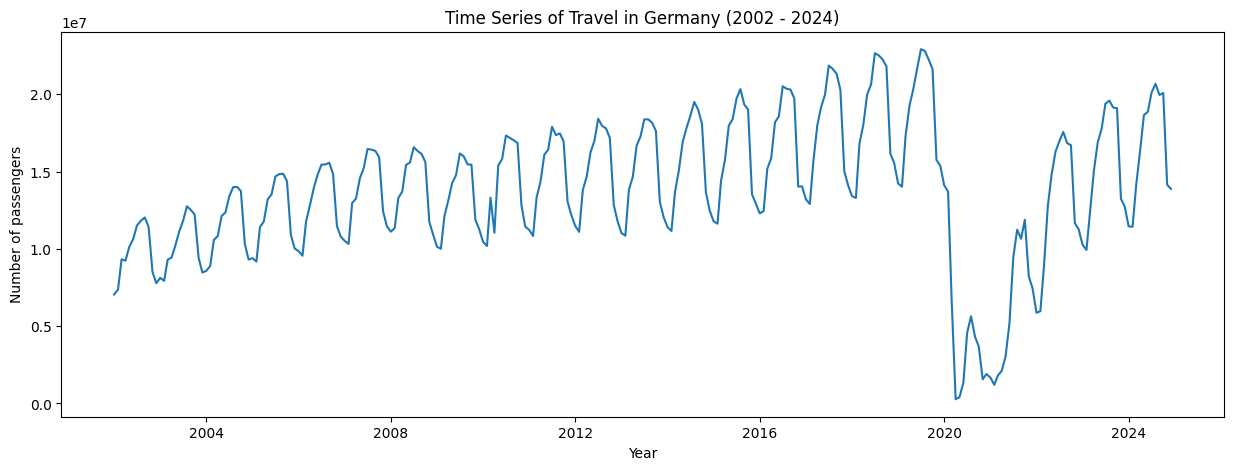

In [20]:
fig, ax = plt.subplots(figsize = (15, 5))
ax.plot(index, data)
ax.set(title = 'Time Series of Travel in Germany (2002 - 2024)', xlabel='Year', ylabel = 'Number of passengers')
# ag_cleaned.loc['2022': '2024']['Total_Passengers'].plot(figsize=(15, 5), xlim=['2022', '2024'])

In [21]:
## EWMA - Exponential Weighted Moving Average. (alpha is a smoothing factor)
ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\306907157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()


In [22]:
ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\232709973.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.8'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.8, adjust = False).mean()


In [23]:
ob_cleaned['EMA_0.7'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.7, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\399242477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.7'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.7, adjust = False).mean()


<Axes: xlabel='TIME_PERIOD'>

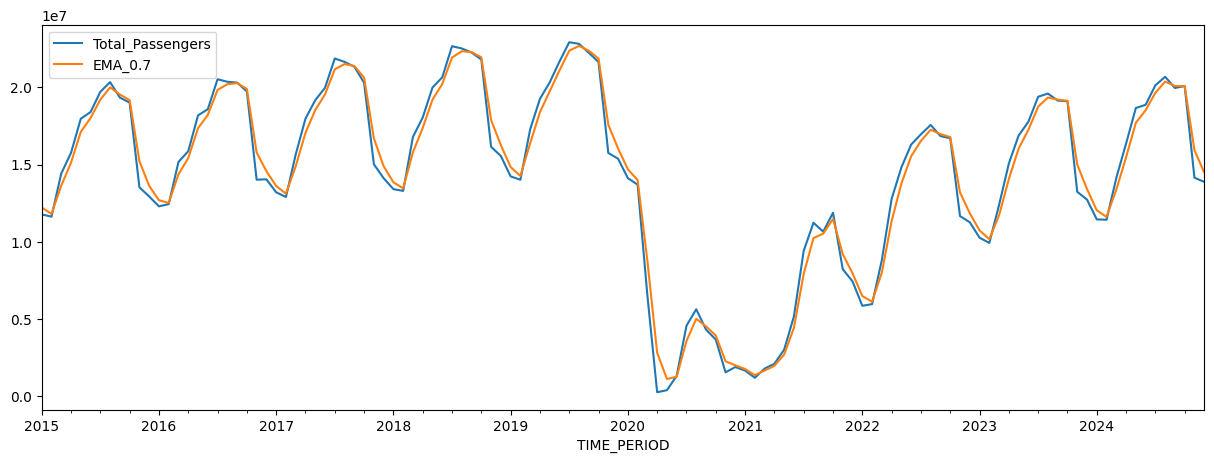

In [24]:
ob_cleaned.loc['2015' :' 2024'][['Total_Passengers', 'EMA_0.7']].plot(figsize=(15, 5))

In [25]:
ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
ob_cleaned['EMA_0.75'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.75, adjust = False).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\2579157987.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.3'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.3, adjust = False).mean()
C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\2579157987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['EMA_0.75'] = ob_cleaned['Total_Passengers'].ewm(alpha = 0.75, adjust = False).mean()


<Axes: xlabel='TIME_PERIOD'>

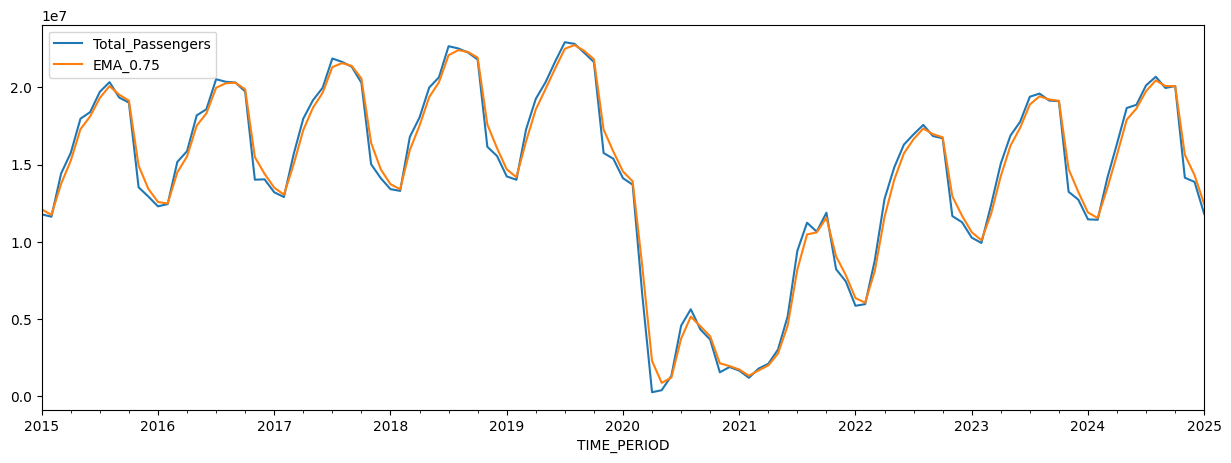

In [26]:
## EWMA - Exponential Weighted Moving Average
ob_cleaned.loc['2015': '2025'][['Total_Passengers', 'EMA_0.75']].plot(figsize=(15, 5))

In [27]:
ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\2308598096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Rolling_window2'] = ob_cleaned['Total_Passengers'].rolling(window=2).mean()


<Axes: xlabel='TIME_PERIOD'>

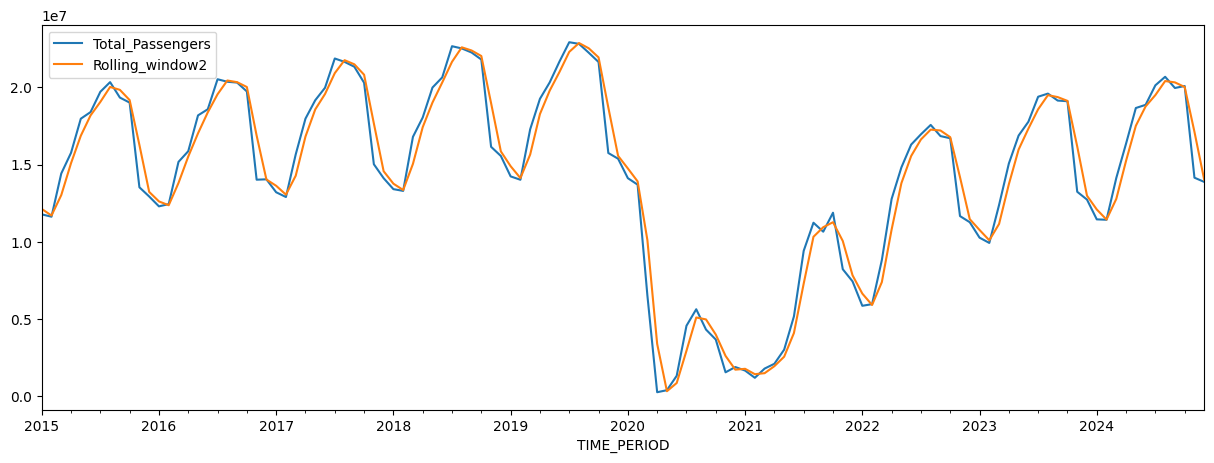

In [28]:
## EWMA - Exponential Weighted Moving Average
ob_cleaned.loc['2015': '2024'][['Total_Passengers', 'Rolling_window2']].plot(figsize=(15, 5))

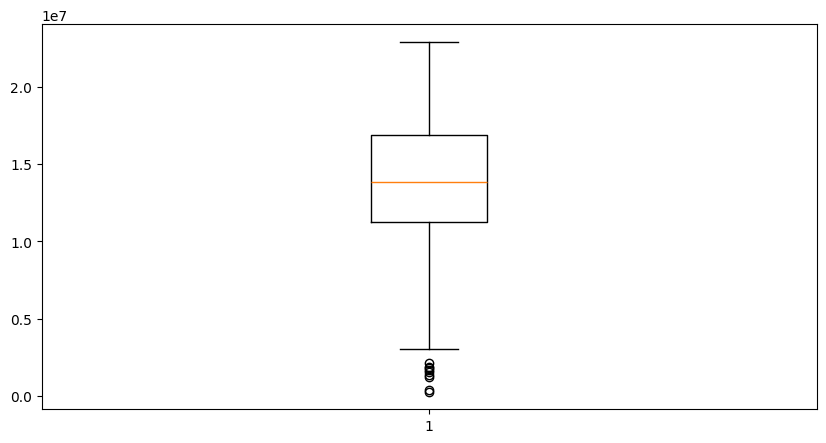

In [29]:
fig, ax = plt.subplots(figsize = (10,5 ))
ax.boxplot(x = 'Total_Passengers', data=ob_cleaned)
plt.show()

In [30]:
result = adfuller(ob_cleaned['Total_Passengers'])

z = (x - u) / s

In [31]:
# H0 = The graph is not stationary
# H1 = The graph is stationary

def adfuller_test(series):
    result = adfuller(series)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))

    if result[1] <= 0.05:
        print('We reject the null. The graph is stationary')
    else:
        print('We accept the null hypothesis, the graph is indeed not stationary')    

In [32]:
adfuller_test(ob_cleaned['Total_Passengers'])

ADF Test Statistic : -3.659785129833758
p-value : 0.004715716764461448
#Lags used : 13
We reject the null. The graph is stationary


In [33]:
ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\3573525325.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_First_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(1)


<Axes: xlabel='TIME_PERIOD'>

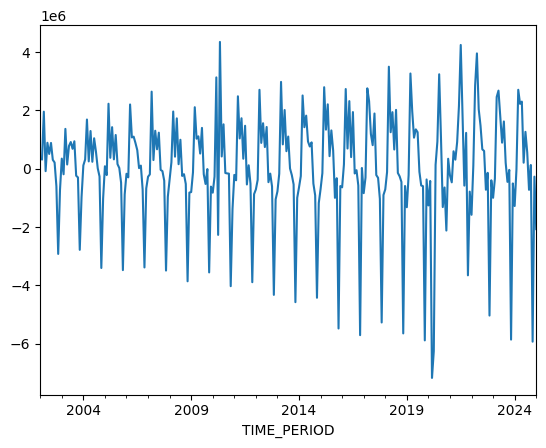

In [34]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

In [35]:
ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\939315197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ob_cleaned['Total_Passengers_Twelve_Difference'] = ob_cleaned['Total_Passengers'] - ob_cleaned['Total_Passengers'].shift(12)


In [36]:
ob_cleaned[['Total_Passengers', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference']]

,Total_Passengers,Total_Passengers_First_Difference,Total_Passengers_Twelve_Difference
TIME_PERIOD,,,
2002-01-01,7044282,NaN,NaN
2002-02-01,7365242,320960.0,NaN
2002-03-01,9319495,1954253.0,NaN
2002-04-01,9235463,-84032.0,NaN
2002-05-01,10124069,888606.0,NaN
...,...,...,...
2024-09-01,19947957,-723872.0,813740.0
2024-10-01,20074786,126829.0,981930.0
2024-11-01,14147115,-5927671.0,910590.0


In [37]:
adfuller_test(ob_cleaned['Total_Passengers_First_Difference'].dropna())

ADF Test Statistic : -4.076495182962014
p-value : 0.0010588904145885337
#Lags used : 15
We reject the null. The graph is stationary


In [38]:
adfuller_test(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

ADF Test Statistic : -3.9757555991194717
p-value : 0.0015429203708297356
#Lags used : 13
We reject the null. The graph is stationary


<Axes: xlabel='TIME_PERIOD'>

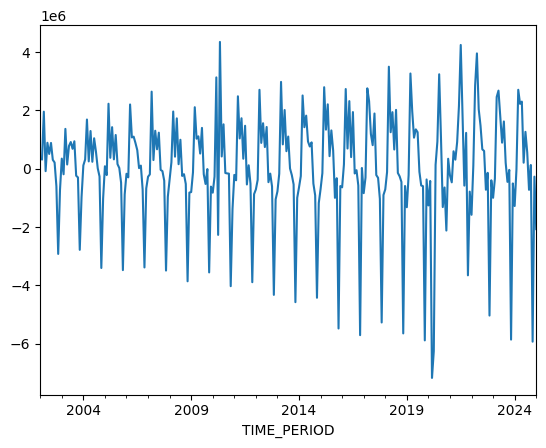

In [39]:
ob_cleaned['Total_Passengers_First_Difference'].plot()

<Axes: xlabel='TIME_PERIOD'>

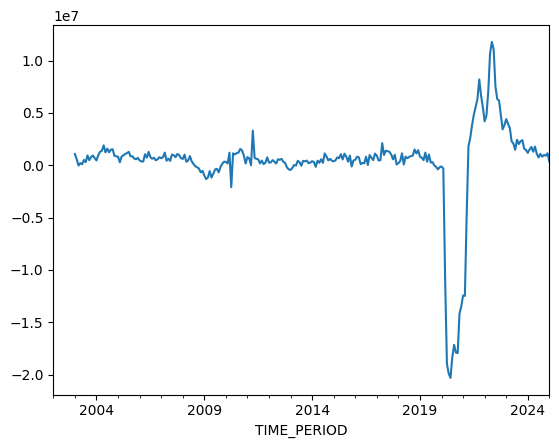

In [40]:
ob_cleaned['Total_Passengers_Twelve_Difference'].plot()

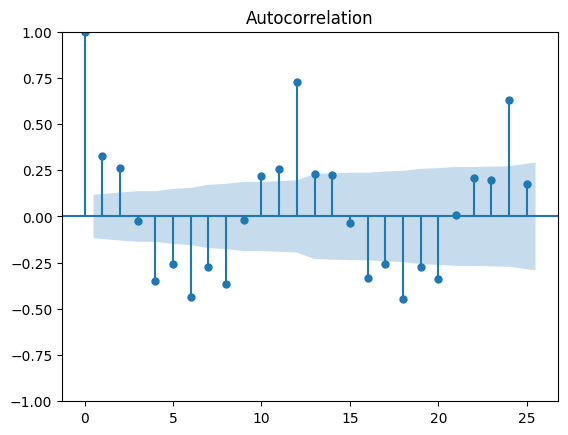

In [41]:
acf = plot_acf(ob_cleaned['Total_Passengers_First_Difference'].dropna())

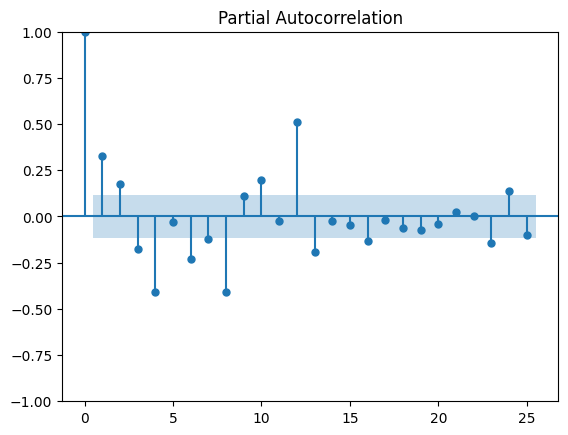

In [42]:
pacf = plot_pacf(ob_cleaned['Total_Passengers_First_Difference'].dropna())
#p = 25
#p = 13

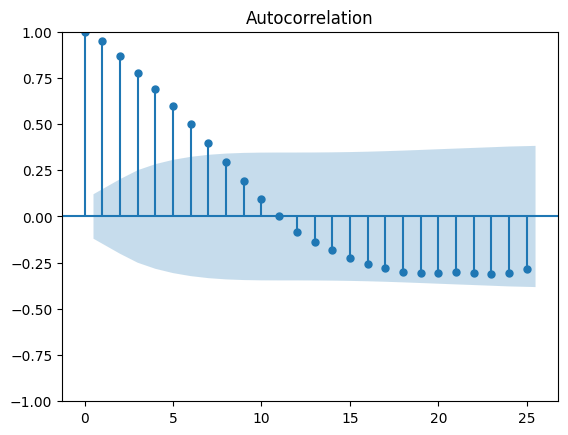

In [43]:
acf12 = plot_acf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

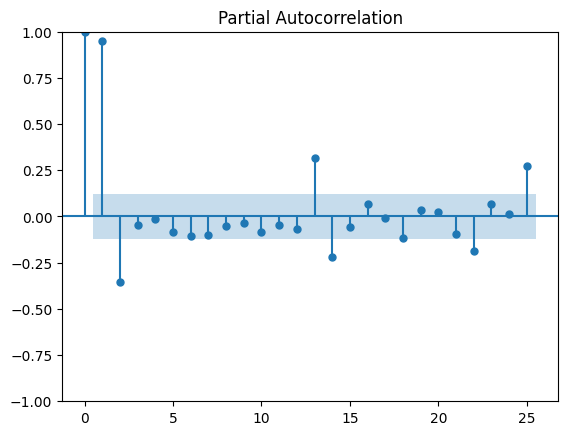

In [44]:
pacf12 = plot_pacf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

In [45]:
ob_cleaned['TIME_PERIOD'].max()

Timestamp('2025-01-01 00:00:00')

In [46]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2022, 12, 1)
test_dataset_end = datetime(2025, 1, 1)

In [47]:
train_data = ob_cleaned[:train_dataset_end]
test_data = ob_cleaned[train_dataset_end + timedelta(days = 1): test_dataset_end]

In [48]:
model_ARIMA = ARIMA(train_data['Total_Passengers'], order = (12, 1, 12))

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [49]:
model_ARIMA_fit = model_ARIMA.fit()

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [50]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       Total_Passengers   No. Observations:                  252
Model:               ARIMA(12, 1, 12)   Log Likelihood               -3844.214
Date:                Tue, 10 Jun 2025   AIC                           7738.429
Time:                        10:34:31   BIC                           7826.565
Sample:                    01-01-2002   HQIC                          7773.897
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2112      0.253      0.834      0.404      -0.285       0.707
ar.L2          0.0353      0.230      0.154      0.878      -0.415       0.486
ar.L3         -0.2733      0.237     -1.152      0.249      -0.738       0.192
ar.L4         -0.0688      0.232     -0.297      0.767      -0.523       0.385
ar.L5          0.2214      0.237      0.933      0.351      -0.243       0.686
ar.L6         -0.0429      0.213     -0.201      0.840      -0.460       0.374
ar.L7         -0.3189      0.214     -1.489      0.136      -0.738       0.101
ar.L8         -0.0884      0.222     -0.398      0.690      -0.523       0.346
ar.L9          0.2802      0.261      1.075      0.282      -0.231       0.791
ar.L10         0.0081      0.224      0.036      0.971      -0.430       0.447
ar.L11        -0.3202      0.216     -1.483      0.138      -0.743       0.103
ar.L12         0.8400      0.207      4.051      0.000       0.434       1.246
ma.L1          0.0113      0.258      0.044      0.965      -0.494       0.517
ma.L2         -0.0368      0.302     -0.122      0.903      -0.628       0.555
ma.L3          0.1659      0.296      0.560      0.575      -0.415       0.746
ma.L4          0.0145      0.270      0.054      0.957      -0.515       0.544
ma.L5         -0.2173      0.270     -0.806      0.420      -0.746       0.311
ma.L6          0.0801      0.226      0.355      0.723      -0.362       0.522
ma.L7          0.3097      0.243      1.276      0.202      -0.166       0.786
ma.L8          0.1113      0.224      0.497      0.619      -0.328       0.551
ma.L9         -0.2922      0.267     -1.095      0.273      -0.815       0.231
ma.L10        -0.0477      0.234     -0.204      0.838      -0.505       0.410
ma.L11         0.2192      0.228      0.960      0.337      -0.228       0.667
ma.L12        -0.6319      0.213     -2.967      0.003      -1.049      -0.215
sigma2      1.208e+12    2.8e-13   4.31e+24      0.000    1.21e+12    1.21e+12
===================================================================================
Ljung-Box (L1) (Q):                   5.93   Jarque-Bera (JB):              8009.46
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               4.09   Skew:                            -3.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.19e+40. Standard errors may be unstable.
"""

In [51]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2023-01-01 00:00:00
2025-01-01 00:00:00


In [52]:
pred = model_ARIMA_fit.predict(start = pred_start_date, end = pred_end_date)
residuals = test_data['Total_Passengers'] - pred

<Axes: ylabel='Density'>

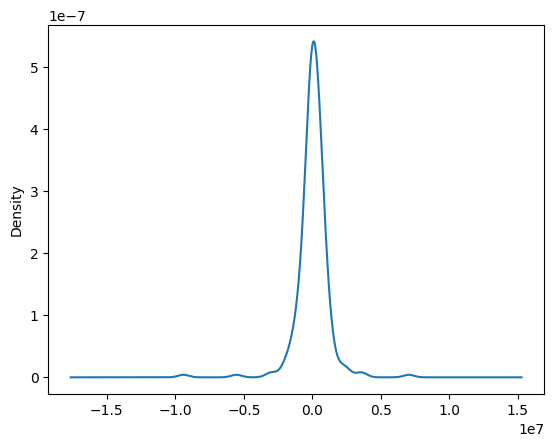

In [53]:
model_ARIMA_fit.resid.plot(kind = 'kde')

In [54]:
test_data['Predicted_ARIMA'] = pred

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\284031954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_ARIMA'] = pred


<Axes: xlabel='TIME_PERIOD'>

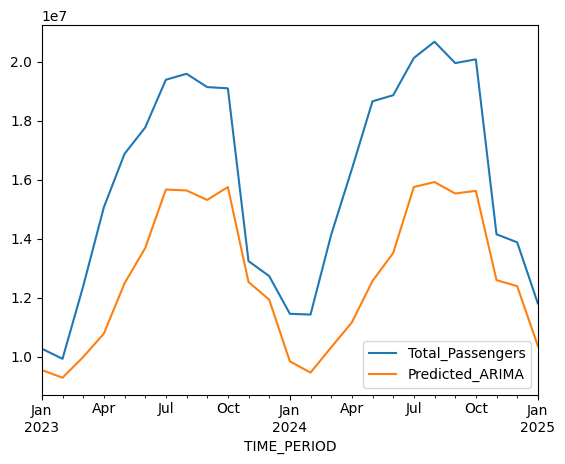

In [55]:
test_data[['Total_Passengers', 'Predicted_ARIMA']].plot()

In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [57]:
ob_cleaned.columns

Index(['unit', 'tra_meas', 'tra_cov', 'geo', 'TIME_PERIOD', 'Total_Passengers',
       'EMA_0.3', 'EMA_0.8', 'EMA_0.7', 'EMA_0.75', 'Rolling_window2',
       'Total_Passengers_First_Difference',
       'Total_Passengers_Twelve_Difference'],
      dtype='object')

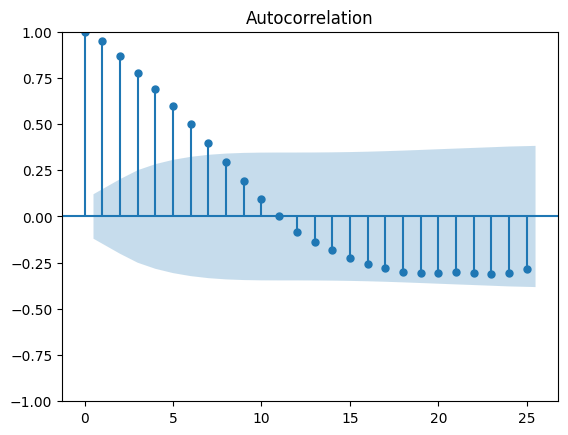

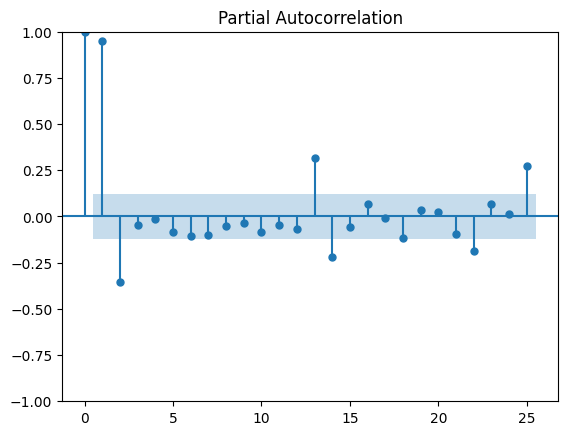

In [58]:
acf12 = plot_acf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())
pacf12 = plot_pacf(ob_cleaned['Total_Passengers_Twelve_Difference'].dropna())

In [59]:
ob_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 277 entries, 2002-01-01 to 2025-01-01
Data columns (total 13 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   unit                                277 non-null    object        
 1   tra_meas                            277 non-null    object        
 2   tra_cov                             277 non-null    object        
 3   geo                                 277 non-null    object        
 4   TIME_PERIOD                         277 non-null    datetime64[ns]
 5   Total_Passengers                    277 non-null    int64         
 6   EMA_0.3                             277 non-null    float64       
 7   EMA_0.8                             277 non-null    float64       
 8   EMA_0.7                             277 non-null    float64       
 9   EMA_0.75                            277 non-null    float64       
 10  Rolling

In [60]:
ob_cleaned.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1 )

,unit,tra_meas,tra_cov,geo,TIME_PERIOD,Total_Passengers,EMA_0.3,EMA_0.8,EMA_0.7,EMA_0.75
TIME_PERIOD,,,,,,,,,,
2002-01-01,Passenger,Passengers on board,Total transport,Germany,2002-01-01,7044282,7.044282e+06,7.044282e+06,7.044282e+06,7.044282e+06
2002-02-01,Passenger,Passengers on board,Total transport,Germany,2002-02-01,7365242,7.140570e+06,7.301050e+06,7.268954e+06,7.285002e+06
2002-03-01,Passenger,Passengers on board,Total transport,Germany,2002-03-01,9319495,7.794248e+06,8.915806e+06,8.704333e+06,8.810872e+06
2002-04-01,Passenger,Passengers on board,Total transport,Germany,2002-04-01,9235463,8.226612e+06,9.171532e+06,9.076124e+06,9.129315e+06
2002-05-01,Passenger,Passengers on board,Total transport,Germany,2002-05-01,10124069,8.795849e+06,9.933562e+06,9.809685e+06,9.875381e+06
...,...,...,...,...,...,...,...,...,...,...
2024-09-01,Passenger,Passengers on board,Total transport,Germany,2024-09-01,19947957,1.899863e+07,2.005938e+07,2.007207e+07,2.007105e+07
2024-10-01,Passenger,Passengers on board,Total transport,Germany,2024-10-01,20074786,1.932148e+07,2.007170e+07,2.007397e+07,2.007385e+07
2024-11-01,Passenger,Passengers on board,Total transport,Germany,2024-11-01,14147115,1.776917e+07,1.533203e+07,1.592517e+07,1.562880e+07


In [61]:
ob_cleaned.columns

Index(['unit', 'tra_meas', 'tra_cov', 'geo', 'TIME_PERIOD', 'Total_Passengers',
       'EMA_0.3', 'EMA_0.8', 'EMA_0.7', 'EMA_0.75', 'Rolling_window2',
       'Total_Passengers_First_Difference',
       'Total_Passengers_Twelve_Difference'],
      dtype='object')

In [62]:
# Assuming ob_cleaned is your DataFrame
# Split the data: last 31 periods for testing, rest for training
training_y = ob_cleaned.iloc[:-31, 5]  # Target variable (Total_Passengers) for training
test_y = ob_cleaned.iloc[-31:, 5]   # Target variable (Total_Passengers) for testing

# Exogenous variables (features from column 6 onwards)
training_X = ob_cleaned.iloc[:-31, 6:]  # Exogenous variables for training
test_X = ob_cleaned.iloc[-31:, 6:]   # Exogenous variables for testing

In [63]:
training_X.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1, inplace=True)
test_X.drop(labels=['Rolling_window2', 'Total_Passengers_First_Difference', 'Total_Passengers_Twelve_Difference'], axis =1, inplace=True)


In [64]:
model = auto_arima(y = training_y,
                   X = training_X,
                   seasonal=True,
                   m = 12)

In [65]:
predictions = pd.Series(model.predict(n_periods=31,
              X = test_X))

<Axes: xlabel='TIME_PERIOD'>

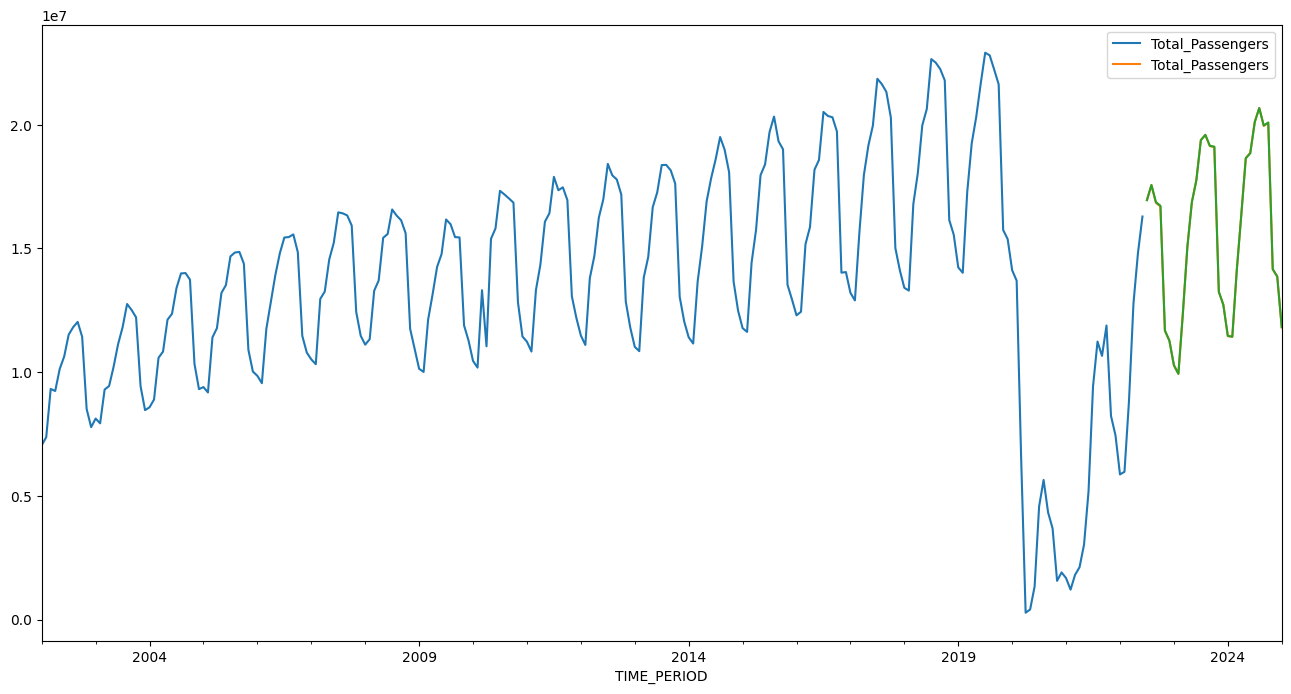

In [66]:
training_y.plot(figsize=(16, 8), legend=True)
test_y.plot(legend=True)
predictions.plot()

In [67]:
model_SARIMA = SARIMAX(train_data['Total_Passengers'], order = (18,1,7), seasonal_order=(0,1,0,12))

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [68]:
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]
print(pred_start_date)
print(pred_end_date)

2023-01-01 00:00:00
2025-01-01 00:00:00


In [69]:
model_SARIMA_fit = model_SARIMA.fit()

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [70]:
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Total_Passengers   No. Observations:                  252
Model:             SARIMAX(18, 1, 7)x(0, 1, [], 12)   Log Likelihood               -3654.669
Date:                              Tue, 10 Jun 2025   AIC                           7361.337
Time:                                      10:36:04   BIC                           7451.725
Sample:                                  01-01-2002   HQIC                          7397.761
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4209      0.736      0.572      0.567      -1.021       1.863
ar.L2         -0.0181      1.009     -0.018      0.986      -1.997       1.960
ar.L3         -0.8594      1.036     -0.829      0.407      -2.891       1.172
ar.L4          0.9959      0.345      2.886      0.004       0.319       1.672
ar.L5         -0.2215      0.515     -0.430      0.667      -1.231       0.789
ar.L6         -0.0339      0.701     -0.048      0.961      -1.407       1.340
ar.L7          0.5521      0.670      0.824      0.410      -0.761       1.865
ar.L8         -0.1924      0.270     -0.713      0.476      -0.721       0.336
ar.L9          0.0190      0.237      0.080      0.936      -0.446       0.484
ar.L10        -0.0579      0.242     -0.239      0.811      -0.533       0.417
ar.L11         0.0611      0.207      0.296      0.767      -0.344       0.466
ar.L12        -0.3502      0.207     -1.688      0.091      -0.757       0.056
ar.L13         0.1351      0.420      0.322      0.748      -0.688       0.958
ar.L14         0.1418      0.468      0.303      0.762      -0.776       1.059
ar.L15        -0.3417      0.387     -0.882      0.378      -1.101       0.418
ar.L16         0.2240      0.174      1.285      0.199      -0.118       0.566
ar.L17         0.0335      0.193      0.174      0.862      -0.344       0.411
ar.L18        -0.2014      0.183     -1.100      0.271      -0.560       0.157
ma.L1         -0.1392      0.751     -0.185      0.853      -1.611       1.333
ma.L2          0.0801      0.797      0.100      0.920      -1.483       1.643
ma.L3          0.8109      0.860      0.943      0.346      -0.875       2.497
ma.L4         -0.9571      0.222     -4.305      0.000      -1.393      -0.521
ma.L5          0.0946      0.564      0.168      0.867      -1.011       1.200
ma.L6         -0.0622      0.641     -0.097      0.923      -1.319       1.195
ma.L7         -0.8137      0.650     -1.252      0.211      -2.088       0.461
sigma2      1.373e+12    1.2e-11   1.14e+23      0.000    1.37e+12    1.37e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             16549.13
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               9.25   Skew:                            -4.14
Prob(H) (two-sided):                  0.00   Kurtosis:                        42.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.7e+39. Standard errors may be unstable.
"""

In [71]:
pred_SARIMA = model_SARIMA_fit.predict(start = datetime(2024, 6, 6), end = datetime(2025, 1, 1))

In [72]:
test_X

,EMA_0.3,EMA_0.8,EMA_0.7,EMA_0.75
TIME_PERIOD,,,,
2022-07-01,1.383740e+07,1.673581e+07,1.652547e+07,1.664291e+07
2022-08-01,1.495395e+07,1.739456e+07,1.724911e+07,1.733016e+07
2022-09-01,1.551924e+07,1.694951e+07,1.696150e+07,1.696122e+07
2022-10-01,1.587249e+07,1.674728e+07,1.677616e+07,1.676285e+07
2022-11-01,1.460993e+07,1.268064e+07,1.319764e+07,1.293870e+07
2022-12-01,1.360701e+07,1.154961e+07,1.184609e+07,1.168481e+07
2023-01-01,1.260589e+07,1.052589e+07,1.074279e+07,1.062367e+07
2023-02-01,1.180220e+07,1.004671e+07,1.017168e+07,1.010111e+07
2023-03-01,1.197698e+07,1.191717e+07,1.172085e+07,1.181387e+07


In [73]:
predictions

2022-07-01    1.694932e+07
2022-08-01    1.756140e+07
2022-09-01    1.686999e+07
2022-10-01    1.672323e+07
2022-11-01    1.168482e+07
2022-12-01    1.126698e+07
2023-01-01    1.028176e+07
2023-02-01    9.931431e+06
2023-03-01    1.237714e+07
2023-04-01    1.506177e+07
2023-05-01    1.686825e+07
2023-06-01    1.774928e+07
2023-07-01    1.937007e+07
2023-08-01    1.958781e+07
2023-09-01    1.914745e+07
2023-10-01    1.910992e+07
2023-11-01    1.325232e+07
2023-12-01    1.271913e+07
2024-01-01    1.146539e+07
2024-02-01    1.142804e+07
2024-03-01    1.412274e+07
2024-04-01    1.635274e+07
2024-05-01    1.863851e+07
2024-06-01    1.884681e+07
2024-07-01    2.010141e+07
2024-08-01    2.067184e+07
2024-09-01    1.996642e+07
2024-10-01    2.008690e+07
2024-11-01    1.416348e+07
2024-12-01    1.385781e+07
2025-01-01    1.181960e+07
Freq: MS, dtype: float64

In [74]:
# residuals = test_X['Total_Passengers'] - predictions

<Axes: ylabel='Density'>

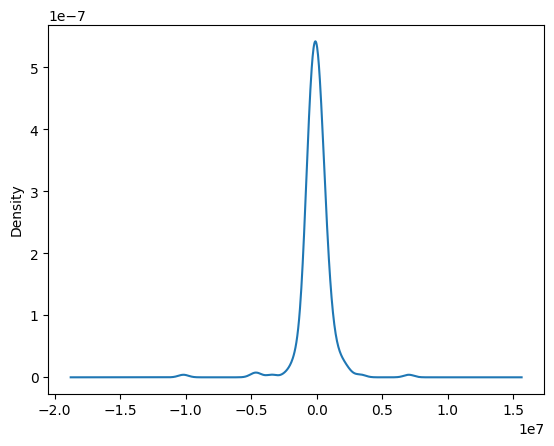

In [75]:
model_SARIMA_fit.resid.plot(kind = 'kde')

In [76]:
test_data['Predicted_SARIMA'] = pred_SARIMA

C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\4184489146.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Predicted_SARIMA'] = pred_SARIMA


## Note for Louis: This doesn't look good. This needs to improve

<Axes: xlabel='TIME_PERIOD'>

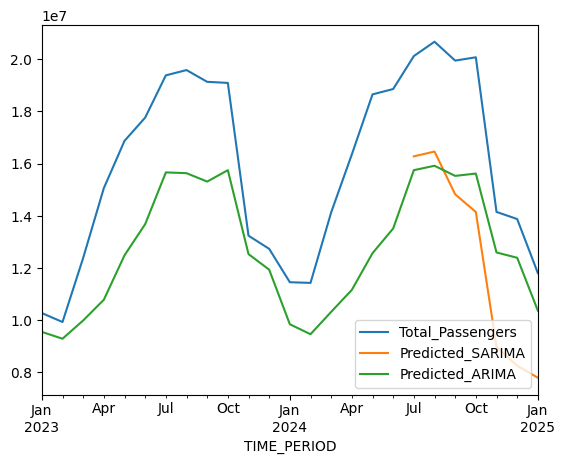

In [77]:
test_data[['Total_Passengers', 'Predicted_SARIMA', 'Predicted_ARIMA']].plot()

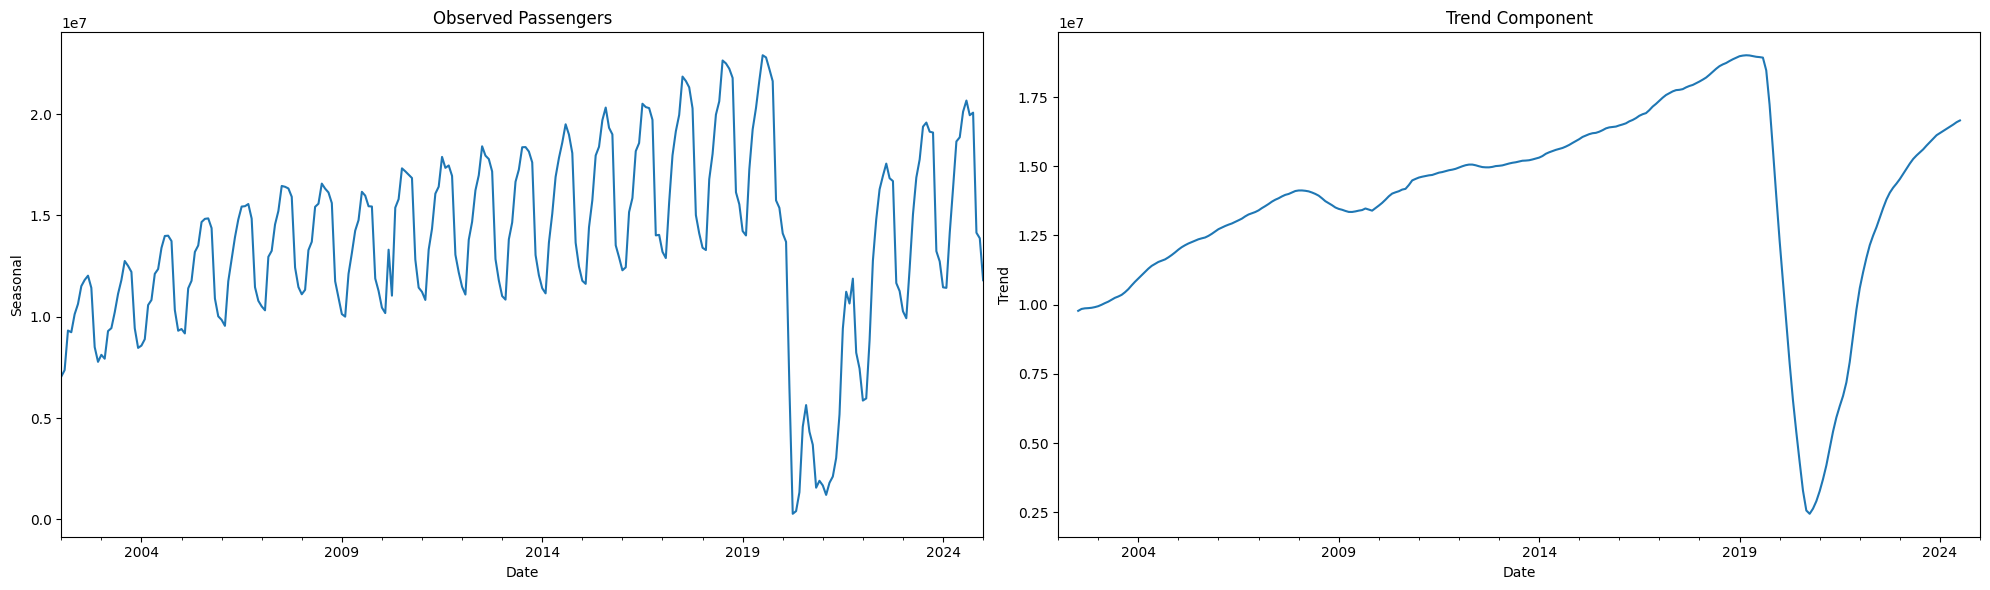

In [78]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_passengers, model='additive', period=12)

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot seasonal component on the first subplot
decomposition.observed.plot(ax=ax1, title = 'Observed Passengers')
ax1.set_xlabel('Date')
ax1.set_ylabel('Seasonal')

# # Plot seasonal component on the first subplot
# decomposition.seasonal.plot(ax=ax1, title='Seasonal Component')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Seasonal')

# Plot trend component on the second subplot
decomposition.trend.plot(ax=ax2, title='Trend Component')
ax2.set_xlabel('Date')
ax2.set_ylabel('Trend')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

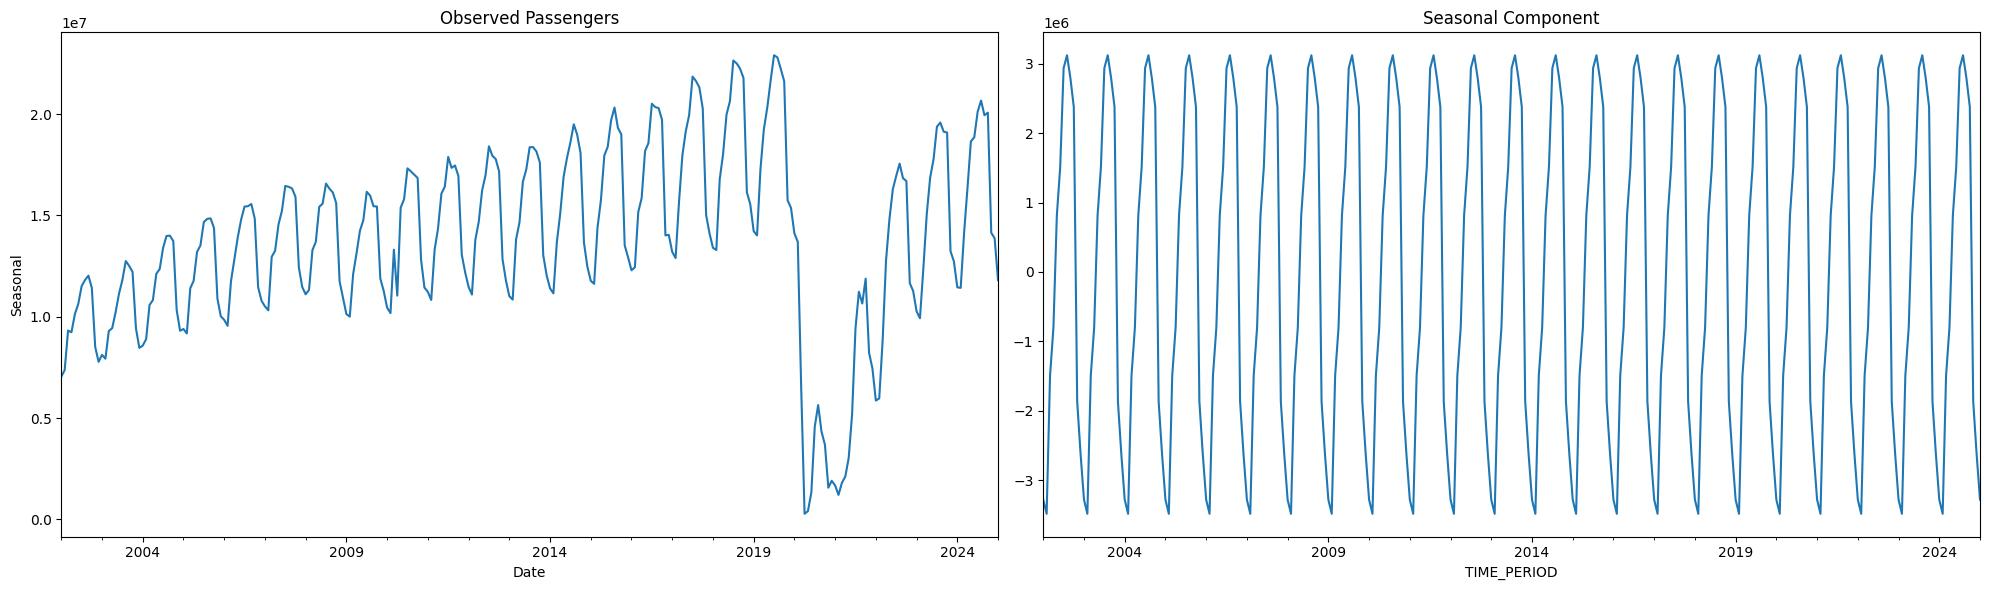

In [79]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition
decomposition = seasonal_decompose(total_passengers, model='additive', period=12)

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))  # 1 row, 2 columns

# Plot seasonal component on the first subplot
decomposition.observed.plot(ax=ax1, title = 'Observed Passengers')
ax1.set_xlabel('Date')
ax1.set_ylabel('Seasonal')

# Plot seasonal component on the first subplot
decomposition.seasonal.plot(ax=ax2, title='Seasonal Component')
ax1.set_xlabel('Date')
ax1.set_ylabel('Seasonal')


# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

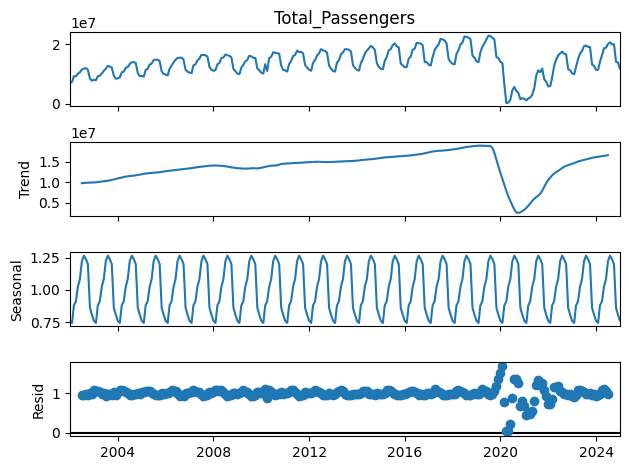

In [80]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition (assuming monthly data with 12 periods per year)
decomposition = seasonal_decompose(total_passengers, model='multiplicative', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

In [83]:
ob_cleaned['Total_Passengers']

TIME_PERIOD
2002-01-01     7044282
2002-02-01     7365242
2002-03-01     9319495
2002-04-01     9235463
2002-05-01    10124069
                ...   
2024-09-01    19947957
2024-10-01    20074786
2024-11-01    14147115
2024-12-01    13874296
2025-01-01    11803557
Name: Total_Passengers, Length: 277, dtype: int64

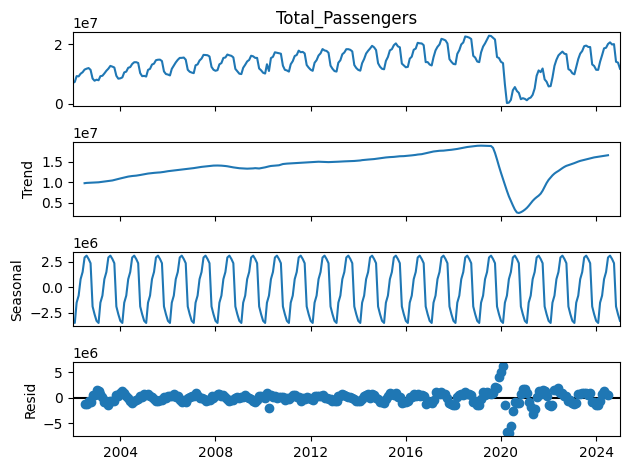

In [81]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Perform seasonal decomposition (assuming monthly data with 12 periods per year)
decomposition = seasonal_decompose(total_passengers, model='subtraction', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

In [87]:
total_passengers.index.max()

Timestamp('2025-01-01 00:00:00')

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\2115165296.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=12, freq='M')[1:]  # Exclude the last known date


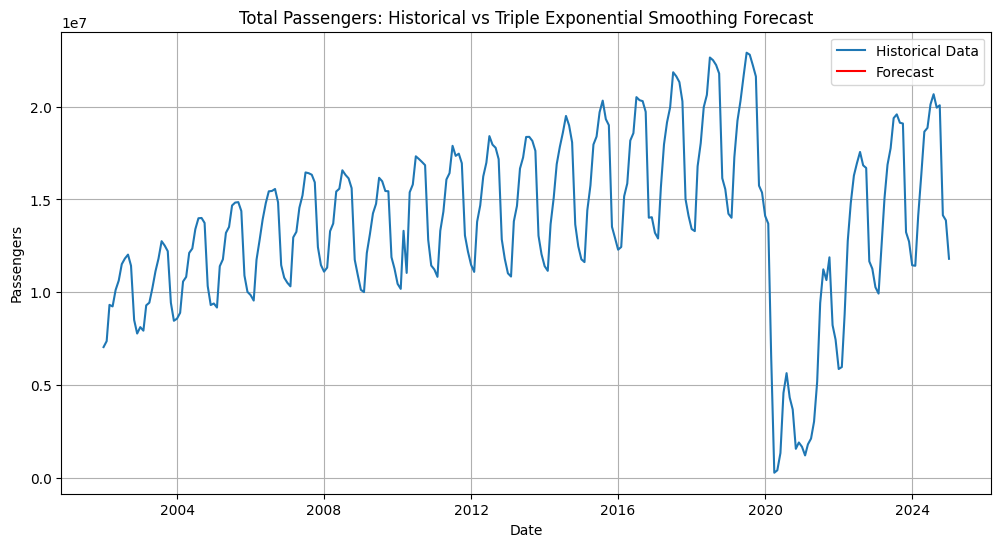

Forecasted values: 2025-02-01    1.204807e+07
2025-03-01    1.406498e+07
2025-04-01    1.474932e+07
2025-05-01    1.592312e+07
2025-06-01    1.637014e+07
2025-07-01    1.739385e+07
2025-08-01    1.733017e+07
2025-09-01    1.698962e+07
2025-10-01    1.681604e+07
2025-11-01    1.282933e+07
2025-12-01    1.264572e+07
2026-01-01    1.225541e+07
2026-02-01    1.243210e+07
2026-03-01    1.444900e+07
2026-04-01    1.513335e+07
2026-05-01    1.630714e+07
2026-06-01    1.675417e+07
2026-07-01    1.777788e+07
2026-08-01    1.771419e+07
2026-09-01    1.737365e+07
2026-10-01    1.720006e+07
2026-11-01    1.321336e+07
2026-12-01    1.302974e+07
2027-01-01    1.263943e+07
2027-02-01    1.281612e+07
2027-03-01    1.483303e+07
2027-04-01    1.551738e+07
2027-05-01    1.669117e+07
2027-06-01    1.713819e+07
2027-07-01    1.816190e+07
2027-08-01    1.809822e+07
Freq: MS, dtype: float64


In [88]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters)
model = ExponentialSmoothing(
    total_passengers,
    seasonal_periods=seasonal_periods,  # Number of periods in a season
    trend='add',  # Additive trend
    seasonal='add',  # Additive seasonality
    initialization_method='heuristic'  # Method to initialize parameters
)

# Fit the model
fit_model = model.fit()

# Forecast the next 31 periods (e.g., 31 months)
forecast = fit_model.forecast(31)

# Create a date range for the forecast
last_date = total_passengers.index[-1]
future_dates = pd.date_range(start=last_date, periods=12, freq='M')[1:]  # Exclude the last known date

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data')
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')
plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.show()

# Print forecast values
print("Forecasted values:", forecast)

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\hassa\AppData\Local\Temp\ipykernel_30044\3980893565.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=last_date, periods=32, freq='M')[1:]  # From Feb 2025 to Aug 2027


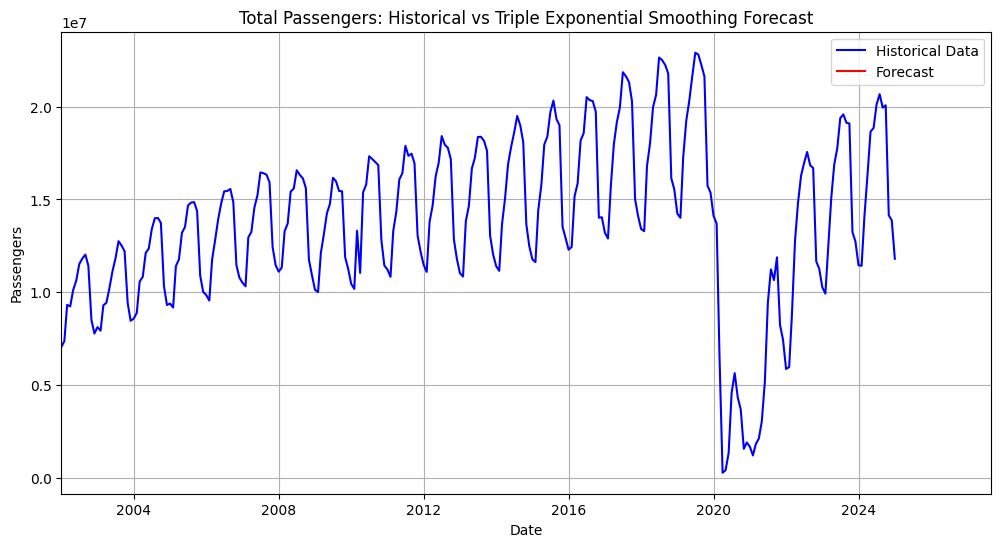

Last historical date: 2025-01-01 00:00:00
Forecasted values: 2025-02-01    1.204807e+07
2025-03-01    1.406498e+07
2025-04-01    1.474932e+07
2025-05-01    1.592312e+07
2025-06-01    1.637014e+07
2025-07-01    1.739385e+07
2025-08-01    1.733017e+07
2025-09-01    1.698962e+07
2025-10-01    1.681604e+07
2025-11-01    1.282933e+07
2025-12-01    1.264572e+07
2026-01-01    1.225541e+07
2026-02-01    1.243210e+07
2026-03-01    1.444900e+07
2026-04-01    1.513335e+07
2026-05-01    1.630714e+07
2026-06-01    1.675417e+07
2026-07-01    1.777788e+07
2026-08-01    1.771419e+07
2026-09-01    1.737365e+07
2026-10-01    1.720006e+07
2026-11-01    1.321336e+07
2026-12-01    1.302974e+07
2027-01-01    1.263943e+07
2027-02-01    1.281612e+07
2027-03-01    1.483303e+07
2027-04-01    1.551738e+07
2027-05-01    1.669117e+07
2027-06-01    1.713819e+07
2027-07-01    1.816190e+07
2027-08-01    1.809822e+07
Freq: MS, dtype: float64


In [94]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt

# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters)
model = ExponentialSmoothing(
    total_passengers,
    seasonal_periods=seasonal_periods,
    trend='add',
    seasonal='add',
    initialization_method='heuristic'
)

# Fit the model
fit_model = model.fit()

# Forecast the next 31 periods (e.g., 31 months)
forecast = fit_model.forecast(31)

# Create a date range for the forecast
last_date = total_passengers.index[-1]  # Should be '2025-01-01'
future_dates = pd.date_range(start=last_date, periods=32, freq='M')[1:]  # From Feb 2025 to Aug 2027

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue')
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits to include the full range
plt.xlim(total_passengers.index[0], future_dates[-1])
plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.show()

# Print forecast values to verify
print("Last historical date:", last_date)
print("Forecasted values:", forecast)

In [100]:
ag_cleaned.columns

Index(['unit', 'tra_meas', 'tra_cov', 'geo', 'TIME_PERIOD',
       'Total_Passengers'],
      dtype='object')

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


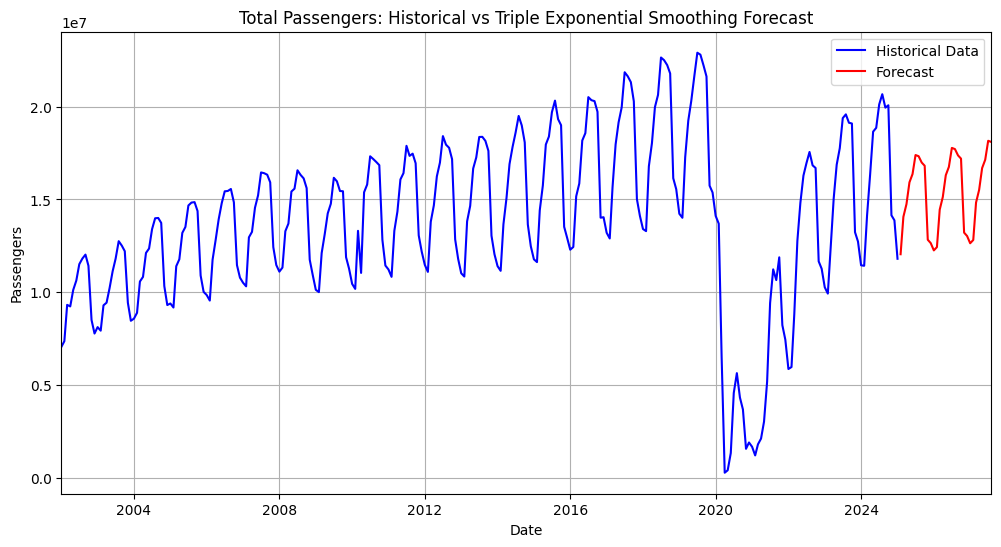

Last historical date: 2025-01-01 00:00:00
Forecast values: 2025-02-01    1.204807e+07
2025-03-01    1.406498e+07
2025-04-01    1.474932e+07
2025-05-01    1.592312e+07
2025-06-01    1.637014e+07
2025-07-01    1.739385e+07
2025-08-01    1.733017e+07
2025-09-01    1.698962e+07
2025-10-01    1.681604e+07
2025-11-01    1.282933e+07
2025-12-01    1.264572e+07
2026-01-01    1.225541e+07
2026-02-01    1.243210e+07
2026-03-01    1.444900e+07
2026-04-01    1.513335e+07
2026-05-01    1.630714e+07
2026-06-01    1.675417e+07
2026-07-01    1.777788e+07
2026-08-01    1.771419e+07
2026-09-01    1.737365e+07
2026-10-01    1.720006e+07
2026-11-01    1.321336e+07
2026-12-01    1.302974e+07
2027-01-01    1.263943e+07
2027-02-01    1.281612e+07
2027-03-01    1.483303e+07
2027-04-01    1.551738e+07
2027-05-01    1.669117e+07
2027-06-01    1.713819e+07
2027-07-01    1.816190e+07
2027-08-01    1.809822e+07
Freq: MS, dtype: float64
Forecast DataFrame:
             Total_Passengers
2025-02-01      1.204807e+07


In [103]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt


# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters)
model = ExponentialSmoothing(
    total_passengers,
    seasonal_periods=seasonal_periods,
    trend='add',
    seasonal='add',
    initialization_method='heuristic'
)

# Fit the model
fit_model = model.fit()

# Forecast the next 31 periods
forecast = fit_model.forecast(31)

# Create a date range for the forecast starting from '2025-02-01'
future_dates = pd.date_range(start='2025-02-01', periods=31, freq='MS')  # MS for start of month

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue')
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits to include the full range
plt.xlim(total_passengers.index[0], future_dates[-1])
plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.show()

# Print to verify
print("Last historical date:", total_passengers.index[-1])
print("Forecast values:", forecast)
print("Forecast DataFrame:\n", forecast_df)

c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\hassa\File_Hub\Documents\Projects\Air-Passenger-Time-Series\airpassenger\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


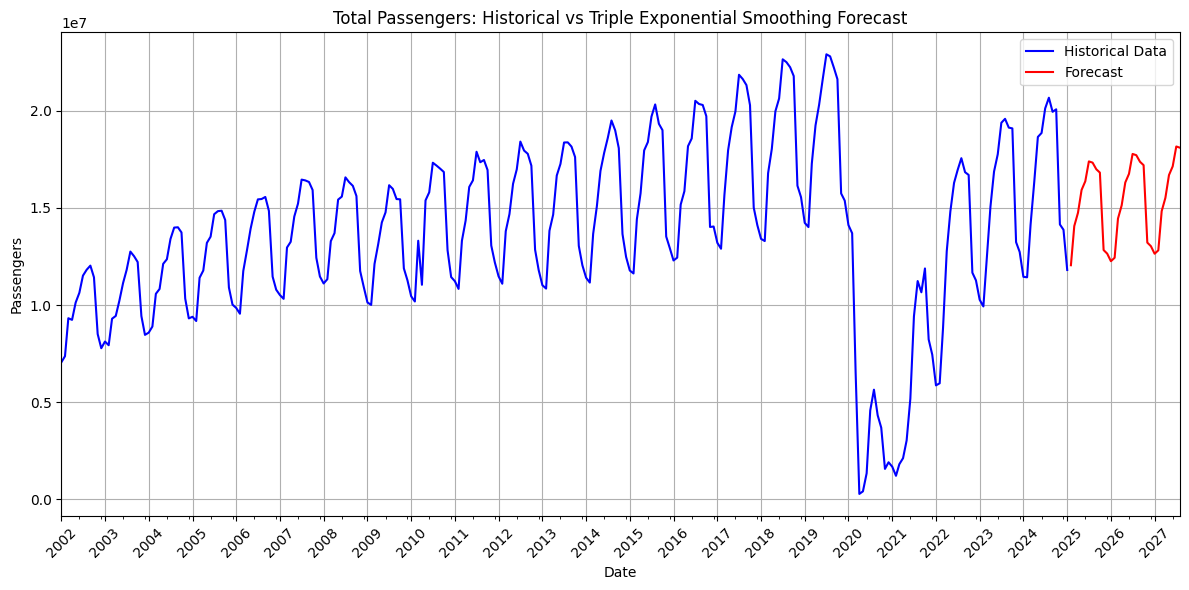

Last historical date: 2025-01-01 00:00:00
Forecast values: 2025-02-01    1.204807e+07
2025-03-01    1.406498e+07
2025-04-01    1.474932e+07
2025-05-01    1.592312e+07
2025-06-01    1.637014e+07
2025-07-01    1.739385e+07
2025-08-01    1.733017e+07
2025-09-01    1.698962e+07
2025-10-01    1.681604e+07
2025-11-01    1.282933e+07
2025-12-01    1.264572e+07
2026-01-01    1.225541e+07
2026-02-01    1.243210e+07
2026-03-01    1.444900e+07
2026-04-01    1.513335e+07
2026-05-01    1.630714e+07
2026-06-01    1.675417e+07
2026-07-01    1.777788e+07
2026-08-01    1.771419e+07
2026-09-01    1.737365e+07
2026-10-01    1.720006e+07
2026-11-01    1.321336e+07
2026-12-01    1.302974e+07
2027-01-01    1.263943e+07
2027-02-01    1.281612e+07
2027-03-01    1.483303e+07
2027-04-01    1.551738e+07
2027-05-01    1.669117e+07
2027-06-01    1.713819e+07
2027-07-01    1.816190e+07
2027-08-01    1.809822e+07
Freq: MS, dtype: float64
Forecast DataFrame:
             Total_Passengers
2025-02-01      1.204807e+07


In [105]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Extract Total_Passengers as a time series
total_passengers = ob_cleaned['Total_Passengers']

# Define the seasonal period (e.g., 12 for monthly data)
seasonal_periods = 12

# Apply Triple Exponential Smoothing (Holt-Winters)
model = ExponentialSmoothing(
    total_passengers,
    seasonal_periods=seasonal_periods,
    trend='add',
    seasonal='add',
    initialization_method='heuristic'
)

# Fit the model
fit_model = model.fit()

# Forecast the next 31 periods
forecast = fit_model.forecast(31)

# Create a date range for the forecast starting from '2025-02-01'
future_dates = pd.date_range(start='2025-02-01', periods=31, freq='MS')  # MS for start of month

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'Total_Passengers': forecast}, index=future_dates)

# Plot the original data and forecast
plt.figure(figsize=(12, 6))
plt.plot(total_passengers.index, total_passengers, label='Historical Data', color='blue')
plt.plot(forecast_df.index, forecast_df['Total_Passengers'], label='Forecast', color='red')

# Set x-axis limits to include the full range
plt.xlim(total_passengers.index[0], future_dates[-1])

# Format x-axis to show dates
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Major ticks every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format as year
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator(interval=6))  # Minor ticks every 6 months

plt.title('Total Passengers: Historical vs Triple Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)  # Rotate labels for readability
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Print to verify
print("Last historical date:", total_passengers.index[-1])
print("Forecast values:", forecast)
print("Forecast DataFrame:\n", forecast_df)